In [ ]:
import os
import numpy as np
from load_data import *
from sklearn.model_selection import train_test_split
import torch
from torch.nn import *
from models import *
from training import *
from torch.utils.data import *
import matplotlib.pyplot as plt
import time

In [ ]:
# Set torch seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Load data

In [ ]:
params, solutions, basis_space, basis_time, sv_space, sv_time = load_data()

# Upper and lower bound of params
upper_bounds_params = np.array([8.0, 0.3, 0.5, 0.5, 0.5, 0.0])
lower_bounds_params = np.array([4.0, 0.1, -0.1, -0.5, -0.5, -0.3])

# Params mapping to [0, 1]
params = (params - lower_bounds_params) / (upper_bounds_params - lower_bounds_params)

# Split training and test set

In [ ]:
# Splitting train-test

split = 0.9

x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(params, solutions['velocity'], test_size=1-split, random_state=0)
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(params, solutions['pressure'], test_size=1-split, random_state=0)

# Create Dataset class

In [ ]:
# Class for a dataset structure

class CreateDataset(Dataset):

    def __init__(self,x,y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y.reshape(x.shape[0], -1), dtype = torch.float32)  # unique tensor for space and time

    def __getitem__(self,index):
        sample = {
            'feature': self.x[index],
            'label': self.y[index]}
        return sample

    def __len__(self):
        return len(self.x)

# Train the final models

In [ ]:
# Parameters

# Set device for training
device = 'cuda:0'

# Number of neurons per layer
K = 256

# Learning rate
lr = 0.01

# Number of epochs
num_epochs = 500

# K-fold
folds = 5

# Batch size
batch_size = 32

Train epoch 1: loss = 37.89046554353502, error = 0.688709145784378, lr = 0.0099
Train epoch 101: loss = 0.6184854602813721, error = 0.06451061291827095, lr = 0.003148091731809522
Train epoch 201: loss = 0.022968268800112938, error = 0.016569786287016337, lr = 0.001001058742614896
Train epoch 301: loss = 0.015430985556708441, error = 0.013711887382798724, lr = 0.00031832573239207976
Train epoch 401: loss = 0.013212245677908262, error = 0.012706392324633069, lr = 0.00010122410163290076


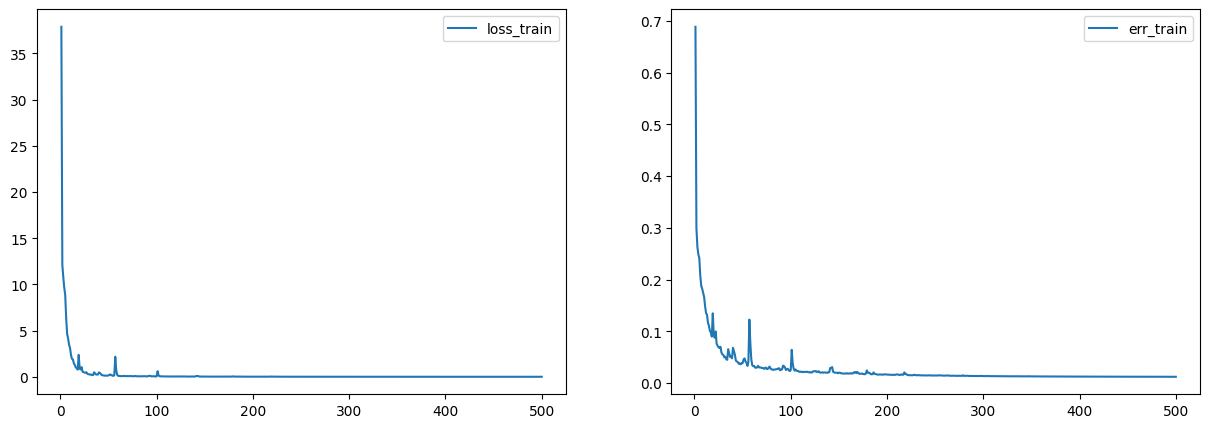

Execution time: 87s


In [ ]:
# Train the final model for velocity

train = CreateDataset(x_train_v, y_train_v)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

train_gen = DataLoader(train, batch_size=batch_size, shuffle=True)

model_v = PTCMapVelocity(K, 40, 37)

start = time.time()

run_training(train_gen, None, num_epochs, model_v, lr, device)

end = time.time()
print('Execution time: {:.0f}s'.format(end - start))

Train epoch 1: loss = 171.63019677056207, error = 0.691947033935123, lr = 0.0099
Train epoch 101: loss = 0.27902507530318366, error = 0.025638361424207688, lr = 0.003148091731809522
Train epoch 201: loss = 0.1155551717016432, error = 0.017304329656892353, lr = 0.001001058742614896
Train epoch 301: loss = 0.06630900351537598, error = 0.013396465058128039, lr = 0.00031832573239207976
Train epoch 401: loss = 0.05743666703502337, error = 0.012483998218344318, lr = 0.00010122410163290076


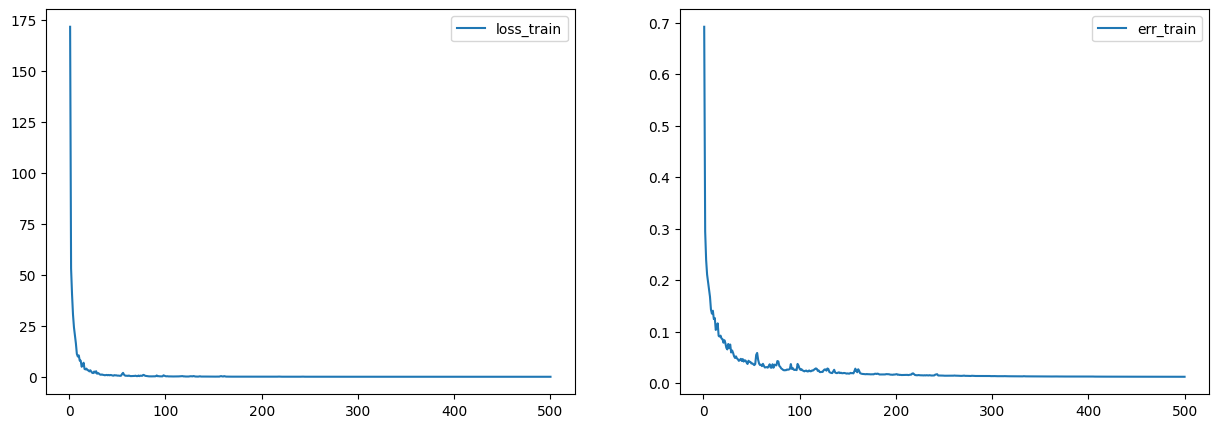

Execution time: 72s


In [ ]:
# Train the final model for pressure

train = CreateDataset(x_train_p, y_train_p)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

train_gen = DataLoader(train, batch_size=batch_size, shuffle=True)

model_p = PTCMapPressure(K, 7, 47)

start = time.time()

run_training(train_gen, None, num_epochs, model_p, lr, device)

end = time.time()
print('Execution time: {:.0f}s'.format(end - start))

# Test the final models

In [ ]:
# Creating pressure and velocity test datasets

test_v = CreateDataset(x_test_v, y_test_v)
test_p = CreateDataset(x_test_p, y_test_p)

In [ ]:
# Test data generators

test_v_gen = DataLoader(test_v, batch_size=len(test_v))
test_p_gen = DataLoader(test_p, batch_size=len(test_p))

In [ ]:
# Compute test error

test_error_v, predictions_v = compute_error(model_v, test_v_gen, device)
print('Velocity test error: {:.2f}%'.format(test_error_v * 100))
test_error_p, predictions_p = compute_error(model_p, test_p_gen, device)
print('Pressure test error: {:.2f}%'.format(test_error_p * 100))

Velocity test error: 1.61%
Pressure test error: 1.72%
